In [4]:
import os
os.chdir("..") # move up one directory

In [5]:
import scipy.stats as stats

from src.extract_load import multiple_csv_to_dict_df
from src.preprocessing import combine_dataframes
from src.text_preprocessing import normalize_corpus, tokenize_text

import pandas as pd
import numpy as np
import pprint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
import time

#Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
#from wordcloud import WordCloud, STOPWORDS

import pprint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
import time
import random
random.seed(2018)

C:\Users\jvaug_000\Anaconda3\envs\group3nlp\lib\site-packages\sklearn\utils\__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
C:\Users\jvaug_000\Anaconda3\envs\group3nlp\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
path = "./data"
dict_df = multiple_csv_to_dict_df(path)

key_filter = ['2014','2015','2016']
dict_df = { your_key: dict_df[your_key] for your_key in key_filter }

#d1 = dict_df['2015']
d1 = combine_dataframes(dict_df)


d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38342 entries, 0 to 38341
Data columns (total 13 columns):
index                                                       38342 non-null int64
HCPCS Code                                                  38342 non-null object
HCPCS Description                                           38342 non-null object
HCPCS Drug Indicator                                        38342 non-null object
Place of Service                                            38342 non-null object
Number of Providers                                         38342 non-null int64
Number of Services                                          38342 non-null int64
Number of Unique Beneficiary/Provider Interactions          38342 non-null int64
Number of Distinct Medicare Beneficiary/Per Day Services    38342 non-null int64
Average Submitted Charge Amount                             38342 non-null float64
Average Medicare Allowed Amount                             38342 non-null 

In [3]:
d2 = d1.loc[:,["HCPCS Description","Average Medicare Standardized Payment Amount"]]
d2.head(5)


,HCPCS Description,Average Medicare Standardized Payment Amount
0,Anesthesia for procedure on salivary gland wit...,188.93
1,Anesthesia for procedure to repair lip defect ...,138.11
2,Anesthesia for procedure on eyelid,122.21
3,Anesthesia for procedure on eyelid,169.81
4,Anesthesia for electric shock treatment,68.51


C:\Users\jvaug_000\Anaconda3\envs\group3nlp\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


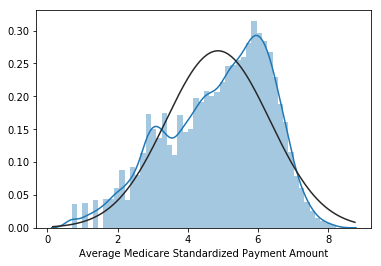

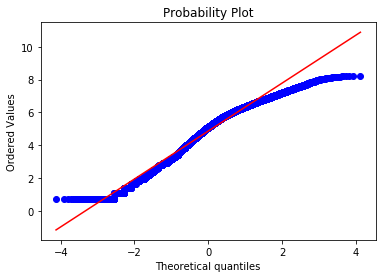

In [4]:
import math
d2 = d2[(d2['Average Medicare Standardized Payment Amount'] > 1) & (d2['Average Medicare Standardized Payment Amount'] <= 4000)]
d2['Average Medicare Standardized Payment Amount'] = d2['Average Medicare Standardized Payment Amount'].apply(lambda x: np.log(math.ceil(x)))

sns.distplot(d2['Average Medicare Standardized Payment Amount'], fit=stats.norm)
fig = plt.figure()
res = stats.probplot(d2['Average Medicare Standardized Payment Amount'], plot=plt)

In [29]:
data = d2

# Hold out a 10% validation set for performance benchmarking
train_data, validation_data = train_test_split(data, test_size=.10, random_state=0)
train_data, validation_data = train_data.copy(), validation_data.copy()

In [ ]:
# Preprocess text
train_text_norm = normalize_corpus(train_data['HCPCS Description'])
# Extract target
train_target = train_data['Average Medicare Standardized Payment Amount']

In [18]:
# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1),
                                   stop_words="english",
                                   max_df=.95,
                                   min_df=.05)
train_tfidf_vectorized = tfidf_vectorizer.fit_transform(train_text_norm)

In [19]:
train_text_norm


['iodine 1123 ioflupane diagnostic per study dose 5 millicurie',
 'clot factor ix ptc christmas measurement',
 'removal forearm bone wrist',
 'cervical vaginal cancer screening pelvic clinical breast examination',
 'drug screen qualitative multiple drug class high complexity test method eg immunoassay enzyme assay per patient encounter',
 'reinsertion ocular implant',
 'mri scan blood vessel abdomen',
 'insertion tissue expander breast',
 'pap test',
 'detection test hepatitis b surface antigen',
 'open treatment broken andor dislocate upper spine bone',
 'xray collar bone',
 'insertion pacemaker pulse generator exist dual lead',
 'repair torn tendon shoulder open procedure',
 'open treatment knee cap dislocation',
 'injection ziconotide 1 microgram',
 'bone andor joint imaging multiple area',
 'removal less 2 centimeter tissue growth beneath skin face scalp',
 'injection xray imaging pulmonary lung artery heart',
 'mri scan one breast contrast',
 'removal mastoid bone implantation coc

In [20]:
# Tuning parameters using a pipeline

pipeline = Pipeline([("vect", TfidfVectorizer(max_features=10000)),
                     ("model", KNeighborsRegressor())])

parameters = {
    "vect__ngram_range": [(1, 3)],  # <- Notice (1, 2) vs (1, 1)
    "vect__max_df": [1.],
    "vect__min_df": [.04],
    "model__n_neighbors": [5,10,25,30,45,50]
    
}

grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs=3)

start = time.time()
grid.fit(train_text_norm, train_target)
stop = time.time()
print("total time: ", stop-start)

total time:  64.17162775993347


In [21]:
# Analyze results
pprint.pprint(grid.best_params_)

# Generate predictions
model = grid.best_estimator_
predict = cross_val_predict(model, train_text_norm, train_target, cv=5, n_jobs=3)
predict_processed = [int(round(i)) for i in predict]
train_target_processed = [int(round(i)) for i in train_target]

# Analyze accuracy
print("Accuracy: %.2f percent" % (accuracy_score(train_target_processed, predict_processed) * 100))
# Analyze Root Mean Squared Error
print("RMSE: %.2f " % np.sqrt(mean_squared_error(np.exp(train_target), np.exp(predict))))

{'model__n_neighbors': 45,
 'vect__max_df': 1.0,
 'vect__min_df': 0.04,
 'vect__ngram_range': (1, 3)}
Accuracy: 33.29 percent
RMSE: 363.65 


In [25]:
np.exp(predict).min()
      

20.953241726041867

In [ ]:
363.65